In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
# import imblearn
# print(imblearn.__version__)
import sys
from time import time
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras import layers
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import Embedding,  SimpleRNN
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.utils import plot_model


## performance metrics for classification
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,confusion_matrix,ConfusionMatrixDisplay,classification_report,plot_confusion_matrix

In [101]:
df = pd.read_csv("cleaned_reviews.csv")
df.head(3)

,Condition,review_text
0,Birth Control,havent gotten pregnant job switched brand another generic get nauseous generally feel tired also headache
1,Birth Control,taking lyza made break horribly tried month bad stopped taking itas inceedible much damaged skin month itas month since stopped taking skin way better still acne really bad scar definitely would take besides acne taking lyza started get period anymore starting month everything else fine didnat give mood swing anything like
2,Birth Control,stuff need removed market harmful age fast dark racoon eye dark mark neck shortness breath horrible mood swing horrible acne enlarged poor hair loss avoid birth control literally plague


In [102]:
df.shape

(50360, 2)

In [103]:
df.isnull().sum()

Condition      0
review_text    0
dtype: int64

In [104]:
df.Condition.value_counts()

High Blood Pressure         19377
Depression                  12686
Birth Control               11940
Type 2 Diabetes Mellitus     6357
Name: Condition, dtype: int64

In [105]:
full_text = " ".join(df['review_text'])
tokens = [review for review in word_tokenize(full_text)]
number_of_words = len(set(tokens))
print("Total number of unique words in the corpus:",number_of_words)

Total number of unique words in the corpus: 39908


## Separating X and Y

In [106]:
X = df.review_text

In [107]:
# encoding the class label
le = LabelEncoder()
Y = le.fit_transform( df['Condition'])
Y = np.array(Y)
Y

array([0, 0, 0, ..., 0, 0, 0])

In [108]:
le.inverse_transform([0,1,2,3])

array(['Birth Control', 'Depression', 'High Blood Pressure',
       'Type 2 Diabetes Mellitus'], dtype=object)

## Train/Test split the data

In [109]:
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    stratify=Y,
                                                    test_size = 0.10,
                                                    random_state = 12)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(45324,) (45324,)
(5036,) (5036,)


In [110]:
X_train.head(2)

42081                                                                    going stop taking colicky baby weight gain started taking baby week old thats got colic
48       switched nuvaring low ogestrel ten day ago gained lb last day extremely active individual work least day week watch eat immediately stopping medication
Name: review_text, dtype: object

In [111]:
print('Y_train:',Counter(Y_train))
print('Y_test:',Counter(Y_test))

Y_train: Counter({2: 17439, 1: 11418, 0: 10746, 3: 5721})
Y_test: Counter({2: 1938, 1: 1268, 0: 1194, 3: 636})


## Tokenization and padding sequences

In [150]:
# creating tokenizer and configuring it to only take into account the top-20000 most frequent words
max_features = 20000
# Maximum number of words(sequence length) for padding sequences
max_seq_len = 50
# embedding layer dimensions
embedding_dim = 100

In [151]:
# word_index = tokenizer.word_index
# print(f'{len(word_index)} unique tokens found.' )

In [197]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenizer.num_words = max_features
x_vectorised = tokenizer.texts_to_sequences(X_train)

x_train_padded = sequence.pad_sequences(x_vectorised , 
                                  maxlen=max_seq_len,
                                  padding='post',
                                  truncating='post')
print('Shape of data tensor:', x_train_padded.shape)
x_train_padded

Shape of data tensor: (45324, 50)


array([[  49,  112,    1, ...,    0,    0,    0],
       [  90,  458,  124, ...,    0,    0,    0],
       [ 182,   56,    0, ...,    0,    0,    0],
       ...,
       [  37,   27,  265, ...,    0,    0,    0],
       [  28,  100,  363, ...,    0,    0,    0],
       [1853,   58,   22, ...,  231,  355,    0]])

In [198]:
x_test_vectorised = tokenizer.texts_to_sequences(X_test)

x_test_padded     = sequence.pad_sequences(x_test_vectorised , 
                                  maxlen=max_seq_len,
                                  padding='post',
                                  truncating='post')
print('Shape of data tensor:', x_test_padded.shape)
x_test_padded

Shape of data tensor: (5036, 50)


array([[  90, 2769,  438, ...,    0,    0,    0],
       [ 355,  122,   18, ...,    0,    0,    0],
       [ 267,  147,   37, ..., 3167,   50,  107],
       ...,
       [ 882,   64, 1625, ...,    0,    0,    0],
       [  53, 7901,   22, ...,    0,    0,    0],
       [ 197,  746,    0, ...,    0,    0,    0]])

In [154]:
Y_train.shape

(45324,)

In [155]:
print(X_train[:1])
print(x_vectorised[:1])

42081    going stop taking colicky baby weight gain started taking baby week old thats got colic
Name: review_text, dtype: object
[[49, 112, 1, 16797, 469, 24, 60, 14, 1, 469, 8, 188, 308, 53, 9056]]


In [156]:
print(word_index['going'])
print(word_index['stop'])

49
112


### calculating class weights

In [157]:
df.Condition.value_counts()

High Blood Pressure         19377
Depression                  12686
Birth Control               11940
Type 2 Diabetes Mellitus     6357
Name: Condition, dtype: int64

In [159]:
#wj=n_samples / (n_classes * n_samplesj)

zero_class = 50360/(4*11940) # Birth Control
print(zero_class)
first_class = 50360/(4*12686) # Depression
print(first_class)
second_class = 50360/(4*19377) # High Blood Pressure
print(second_class)
third_class = 50360/(4*6357) # Type 2 Diabetes Mellitus
print(third_class)

class_weights = {0:zero_class,1:first_class,2:second_class,3:third_class}
class_weights

1.0544388609715243
0.9924326028693048
0.6497393817412396
1.9804939436841278


{0: 1.0544388609715243,
 1: 0.9924326028693048,
 2: 0.6497393817412396,
 3: 1.9804939436841278}

# LSTM witk Keras Embedding Layer

In [160]:
model_lstm = keras.Sequential()
print(max_features, embedding_dim, max_seq_len)
model_lstm.add(Embedding(max_features, embedding_dim, input_length=max_seq_len))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(64,activation='relu'))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(4, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model = model_lstm.summary()

#plot_model(model, to_file='lstm_model.png',show_shapes=True,dpi=96)



20000 100 50
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 50, 100)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_24 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 260       
Total params: 2,087,124
Trainable params: 2,087,124
Non-trainable params: 0
______________________________

In [161]:
epochs = 20
batch_size = 128
start = time()
history = model_lstm.fit(x_train_padded,
                        Y_train, 
                        class_weight=class_weights,
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
                    )
print("Time taken for the model to train & evaluate :",time()-start)

Epoch 1/20
319/319 [==============================] - 39s 117ms/step - loss: 1.0572 - accuracy: 0.4842 - val_loss: 0.5640 - val_accuracy: 0.7529
Epoch 2/20
319/319 [==============================] - 40s 126ms/step - loss: 0.4859 - accuracy: 0.7739 - val_loss: 0.3620 - val_accuracy: 0.8729
Epoch 3/20
319/319 [==============================] - 39s 123ms/step - loss: 0.3143 - accuracy: 0.8790 - val_loss: 0.3406 - val_accuracy: 0.8904
Epoch 4/20
319/319 [==============================] - 39s 122ms/step - loss: 0.2581 - accuracy: 0.9045 - val_loss: 0.3513 - val_accuracy: 0.8720
Epoch 5/20
319/319 [==============================] - 39s 123ms/step - loss: 0.2216 - accuracy: 0.9155 - val_loss: 0.3412 - val_accuracy: 0.8923
Epoch 6/20
319/319 [==============================] - 39s 123ms/step - loss: 0.1912 - accuracy: 0.9265 - val_loss: 0.3388 - val_accuracy: 0.8890
Epoch 7/20
319/319 [==============================] - 39s 122ms/step - loss: 0.1826 - accuracy: 0.9313 - val_loss: 0.3526 - val_ac

In [132]:
acc_lstm = model_lstm.evaluate(x_test_padded,Y_test)
print(f'Test set:\n  Loss: {acc_lstm[0]} \n  Accuracy:{round(acc_lstm[1]*100,2)}%')

158/158 [==============================] - 1s 7ms/step - loss: 0.3768 - accuracy: 0.8946
Test set:
  Loss: 0.3768123984336853 
  Accuracy:89.46%


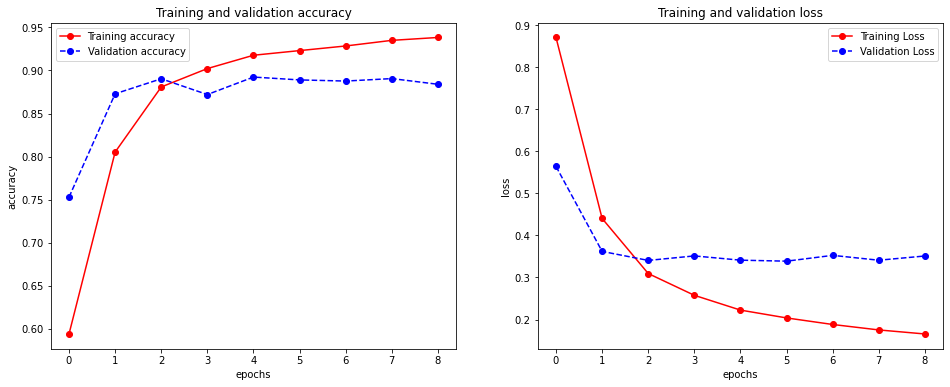

In [163]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_acc))

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(epochs, train_acc, 'r-o', label='Training accuracy')
plt.plot(epochs, val_acc, 'b--o', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'r-o', label='Training Loss')
plt.plot(epochs, val_loss, 'b--o', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.savefig('LSTM_model_result.png')

In [164]:
y_predicted = model_lstm.predict(x_test_padded)

pred_list = list(y_predicted)
predicted_classes = [np.argmax(pred) for pred in pred_list]


Confusion Matrix: 
 [[1142   21   23    8]
 [  22 1142   86   18]
 [  44  173 1626   95]
 [   7   23   76  530]]
 
Classification Report : 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1194
           1       0.84      0.90      0.87      1268
           2       0.90      0.84      0.87      1938
           3       0.81      0.83      0.82       636

    accuracy                           0.88      5036
   macro avg       0.87      0.88      0.88      5036
weighted avg       0.88      0.88      0.88      5036



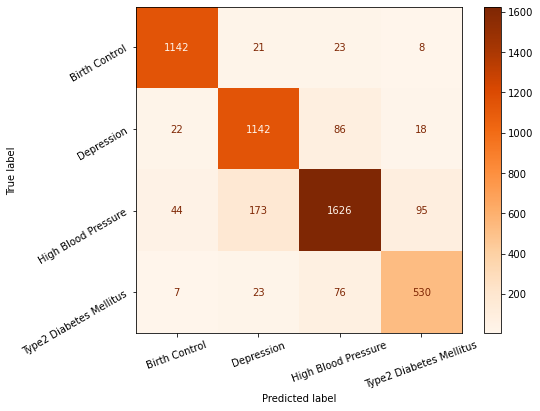

In [165]:
# Plotting Confusion Matrix
import seaborn as sns
cm = confusion_matrix(Y_test, predicted_classes)

print("Confusion Matrix: \n",cm)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Oranges',ax=ax)  
labels = ['Birth Control','Depression','High Blood Pressure','Type2 Diabetes Mellitus']
ax.xaxis.set_ticklabels(labels,rotation=20); ax.yaxis.set_ticklabels(labels,rotation=30);

 ## printing Classification Report: A text report showing the main classification metrics.
print(" ")
print("Classification Report : \n", classification_report(Y_test, predicted_classes))

In [171]:
new_complaint = ['do not take this year old has just attempted to take her own life after months on this pill She was happy go lucky till taking this. I sit here crying writing this seeing what its done to my girl it should be banned']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = sequence.pad_sequences(seq, maxlen=max_seq_len)
pred = model_lstm.predict(padded)
labels = ['Birth Control', 'Depression', 'High Blood Pressure','Type 2 Diabetes Mellitus']
print(pred, labels[np.argmax(pred)])

[[0.20319086 0.38347656 0.35071567 0.0626169 ]] Depression


In [167]:
le.inverse_transform([0,1,2,3])

array(['Birth Control', 'Depression', 'High Blood Pressure',
       'Type 2 Diabetes Mellitus'], dtype=object)

In [168]:
diab_symptoms = ["Thirst Headaches Trouble concentrating Blurred vision Frequent peeing  Weight loss sugar more than 180 "]
seq = tokenizer.texts_to_sequences(diab_symptoms)
padded = sequence.pad_sequences(seq, maxlen=max_seq_len)
pred = model_lstm.predict(padded)
labels = ['Birth Control', 'Depression', 'High Blood Pressure','Type 2 Diabetes Mellitus']
print(pred, labels[np.argmax(pred)])

[[0.00142315 0.28067434 0.06261667 0.6552859 ]] Type 2 Diabetes Mellitus


## LSTM with pretrained vectors(Glove)

In [225]:
embed_dictionary = {}

with open("glove.6B.200d.txt","r",encoding="utf8") as file:
    for each_line in file:
        values = each_line.split()
        each_word = values[0]
        its_vector = np.asarray(values[1:], dtype='float32')
        embed_dictionary[each_word] = its_vector

In [226]:
embed_matrix= np.zeros((len(word_index)+1, 200)) #100

for word, vec in word_index.items():
    if its_index <= len(word_index):
        embedding_vec = embed_dictionary.get(word)
        if embedding_vec is not None:
            embed_matrix[vec] = embedding_vec
embed_matrix.shape

(35050, 200)

In [228]:
from keras.initializers import Constant

model_lstm_glove = keras.Sequential()


model_lstm_glove.add(Embedding(len(word_index)+1, 
                               200,
                               #embedding_dim, 
                               input_length=max_seq_len,
                               embeddings_initializer = Constant(embed_matrix),
                               trainable = False))

model_lstm_glove.add(SpatialDropout1D(0.2))
model_lstm_glove.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm_glove.add(Dense(64,activation='relu'))
model_lstm_glove.add(Dropout(0.1))
model_lstm_glove.add(Dense(4, activation='softmax'))
model_lstm_glove.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model = model_lstm_glove.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 50, 200)           7010000   
_________________________________________________________________
spatial_dropout1d_13 (Spatia (None, 50, 200)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               120400    
_________________________________________________________________
dense_30 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 260       
Total params: 7,137,124
Trainable params: 127,124
Non-trainable params: 7,010,000
_____________________________________

In [229]:
epochs = 25
batch_size = 256
start = time()
history = model_lstm_glove.fit(x_train_padded,
                                Y_train, 
                                class_weight=class_weights,
                                epochs=epochs, 
                                batch_size=batch_size,
                                validation_split=0.1,
                                callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                    )
print("Time taken for the model to train & evaluate :",time()-start)

Epoch 1/25
160/160 [==============================] - 153s 882ms/step - loss: 1.2696 - accuracy: 0.3896 - val_loss: 0.8845 - val_accuracy: 0.6431
Epoch 2/25
160/160 [==============================] - 139s 870ms/step - loss: 0.9111 - accuracy: 0.5571 - val_loss: 0.7557 - val_accuracy: 0.6640
Epoch 3/25
160/160 [==============================] - 139s 872ms/step - loss: 0.7794 - accuracy: 0.6338 - val_loss: 0.6424 - val_accuracy: 0.7203
Epoch 4/25
160/160 [==============================] - 138s 865ms/step - loss: 0.6377 - accuracy: 0.7231 - val_loss: 0.6056 - val_accuracy: 0.7256
Epoch 5/25
160/160 [==============================] - 139s 867ms/step - loss: 0.5775 - accuracy: 0.7453 - val_loss: 0.5091 - val_accuracy: 0.8012
Epoch 6/25
160/160 [==============================] - 138s 863ms/step - loss: 0.5410 - accuracy: 0.7655 - val_loss: 0.5193 - val_accuracy: 0.7895
Epoch 7/25
160/160 [==============================] - 136s 853ms/step - loss: 0.5231 - accuracy: 0.7751 - val_loss: 0.4703 -

In [230]:
acc_lstm = model_lstm_glove.evaluate(x_test_padded,Y_test)
print(f'Test set:\n  Loss: {acc_lstm[0]} \n  Accuracy:{round(acc_lstm[1]*100,2)}%')

158/158 [==============================] - 11s 71ms/step - loss: 0.4464 - accuracy: 0.8320
Test set:
  Loss: 0.4464266002178192 
  Accuracy:83.2%


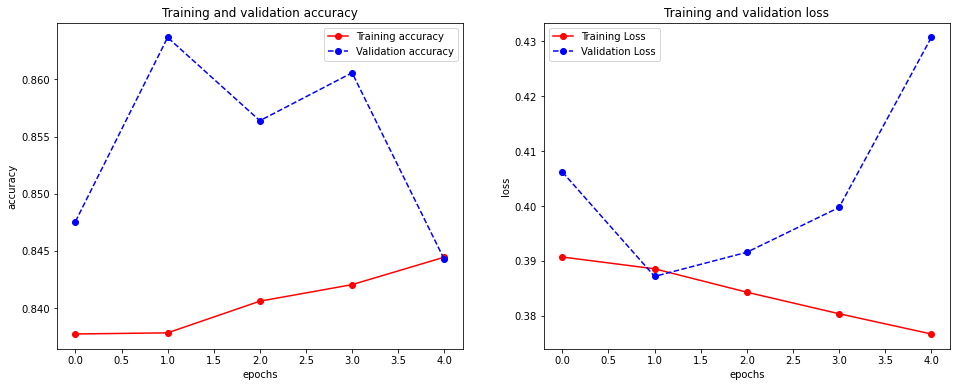

In [217]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_acc))

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(epochs, train_acc, 'r-o', label='Training accuracy')
plt.plot(epochs, val_acc, 'b--o', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'r-o', label='Training Loss')
plt.plot(epochs, val_loss, 'b--o', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


plt.savefig('LSTM_model_Glove_result.png')

In [218]:
new_complaint = ['do not take this year old has just attempted to take her own life after months on this pill She was happy go lucky till taking this. I sit here crying writing this seeing what its done to my girl it should be banned']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = sequence.pad_sequences(seq, maxlen=max_seq_len)
pred = model_lstm.predict(padded)
labels = ['Birth Control', 'Depression', 'High Blood Pressure','Type 2 Diabetes Mellitus']
print(pred, labels[np.argmax(pred)])

[[0.20319086 0.38347656 0.35071567 0.0626169 ]] Depression
